[*********************100%%**********************]  1 of 1 completed
c:\Users\ivoto\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\ivoto\AppData\Local\Temp\ipykernel_1876\2400010668.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context = torch.tensor(train_df["Close"])


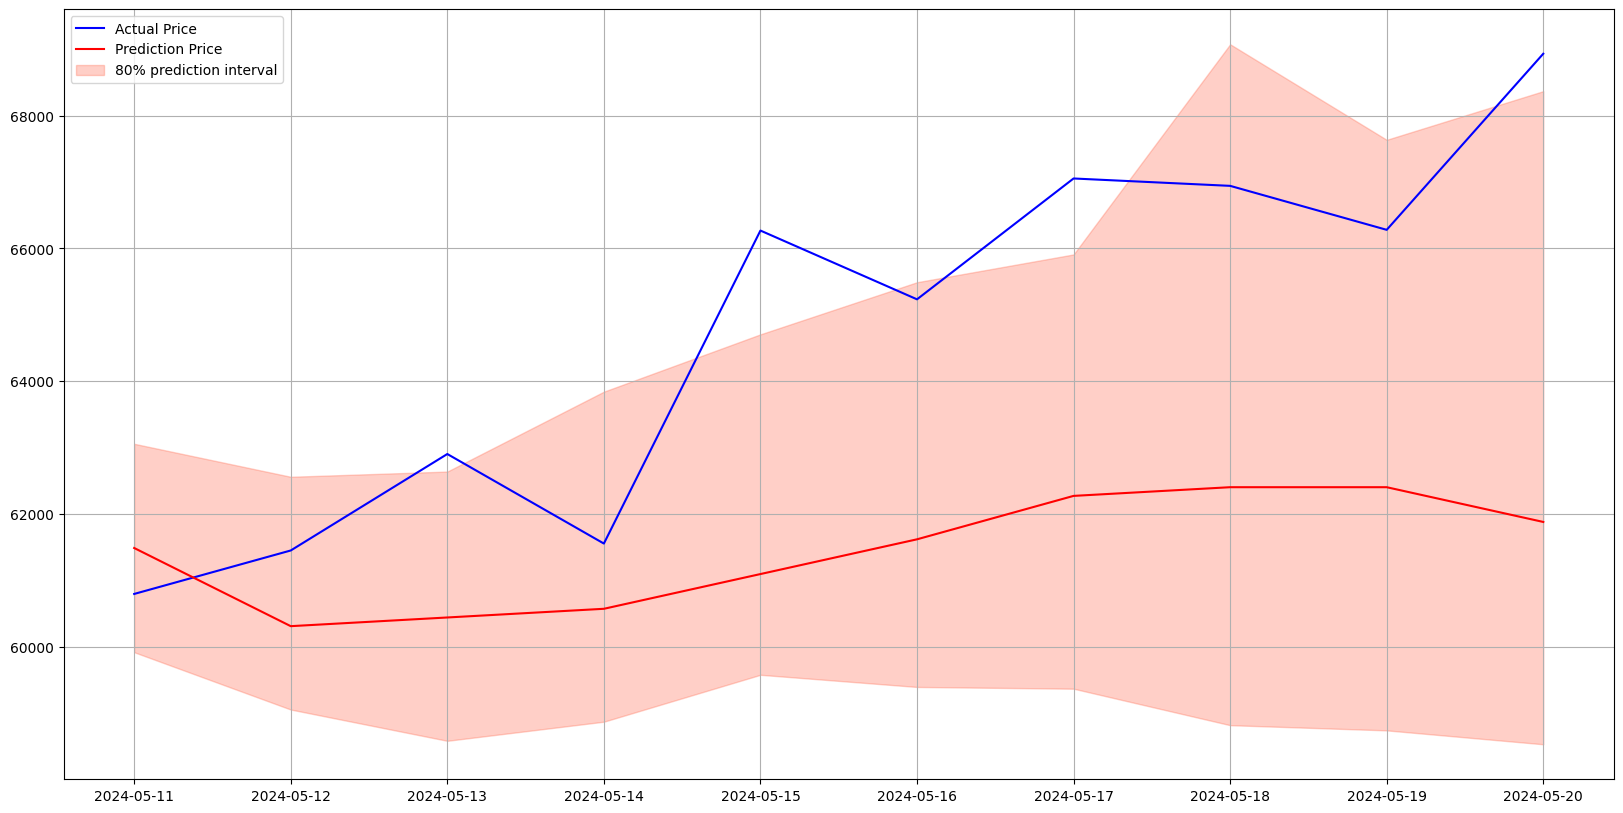

In [21]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from chronos import ChronosPipeline
import yfinance as yf

token = "BTC-USD"
token = yf.download(token)
token.to_csv("BTC-USD.csv")


df = pd.read_csv("BTC-USD.csv", index_col="Date", parse_dates=True)
df.dropna(inplace=True)

dias = 10

train_size = int(len(df) - dias)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

#Hacemos las predicciones
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

prediction_length = dias
context = torch.tensor(train_df["Close"])
forecast = pipeline.predict(context, prediction_length)

low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(20,10))
plt.plot(test_df.index, test_df["Close"], label="Actual Price",color="blue")
plt.plot(test_df.index, median, color="red", label="Prediction Price")
plt.fill_between(test_df.index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
from pathlib import Path
from typing import List, Optional, Union
import pandas as pd
import numpy as np
from gluonts.dataset.arrow import ArrowWriter




def convert_to_arrow(
    path: Union[str, Path],
    time_series: Union[List[np.ndarray], np.ndarray],
    start_times: Optional[Union[List[np.datetime64], np.ndarray]] = None,
    compression: str = "lz4",
):
    if start_times is None:
        # Set an arbitrary start time
        start_times = [np.datetime64("2000-01-01 00:00", "s")] * len(time_series)

    assert len(time_series) == len(start_times)

    dataset = [
        {"start": start, "target": ts} for ts, start in zip(time_series, start_times)
    ]
    ArrowWriter(compression=compression).write_to_file(
        dataset,
        path=path,
    )


if __name__ == "__main__":
    df = pd.read_csv("BTC-USD.csv", index_col="Date", parse_dates=True)
    time_series = [df['Close'].values]
    start_times = [df.index.values[0]]
    
    convert_to_arrow("./bitcoin_prices.arrow", time_series=time_series, start_times=start_times)


In [12]:
import yfinance as yf

tick = "BTC-USD"

token = yf.download(tick)

print(token.type)

[*********************100%%**********************]  1 of 1 completed


AttributeError: 'DataFrame' object has no attribute 'type'